In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, ShuffleSplit
import networkx as nx

import itertools

from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
import tensorflow as tf

In [3]:
from common.adjacency_list_to_graph import build_graph
from common.calculate_spring_rank import calculate_spring_rank
from common.graph_to_matrix import build_matrix

In [4]:
transactions_df = pd.read_csv("./part_data", sep=" ", names=["from", "to", "value", "block"])
transactions_df["value"] = 1
transactions_df = transactions_df.sort_values("block")

Для теста используем граф с выраженной иерархией, например, граф цитат

In [22]:
transactions_df = pd.read_csv("Cit-HepPh.txt", sep="\t", names=["from", "to"])
transactions_df["value"] = 1

In [5]:
def create_dataset(dataset, addresses=None):
    if addresses:
        dataset = dataset[dataset["from"].isin(addresses) & dataset["to"].isin(addresses)]
    return dataset.groupby(["from", "to"])["value"].sum().to_frame()

In [6]:
def find_ranks(dataset, alpha):
    edges = dataset["value"].to_dict()
    graph = build_graph(edges)
    nodes = list(graph)
    A = build_matrix(graph, nodes)
    iterations, raw_rank = calculate_spring_rank(A, alpha=alpha)
    
    rank = pd.DataFrame()
    rank["address"] = nodes
    rank["rank"] = raw_rank
    
    return rank.set_index("address")

Модель предсказания дуг:
$$P_{ij} = \frac{1}{1 + e^{-2\beta(s_i - s_j)}}$$
$$P_{ji} = \frac{1}{1 + e^{2\beta(s_i - s_j)}} $$
$$P_{ij} = 1 - P_{ji}$$

$$E_{ij} = c \exp{-\frac{\beta}{2}(s_i - s_j - 1)^2}$$

In [7]:
# def predict_edges(dataset, ranks, beta):
#     dataset["from_rank"] = ranks.loc[[a for a, _ in dataset.index]]["rank"].tolist()
#     dataset["to_rank"] = ranks.loc[[b for _, b in dataset.index]]["rank"].tolist()
#     return (1 / (1 + np.exp(-2 * beta * (dataset["from_rank"] - dataset["to_rank"])))).tolist()

In [8]:
s = tf.Session()

In [9]:
def predict_edges_sum(dataset, ranks, beta, c):
    addresses = set([a for a, _ in dataset.index] + [b for _, b in dataset.index])
    ranks = ranks.loc[addresses]["rank"].tolist()
    dataset_shape = len(ranks)
    batch_shape = 10000
    assert dataset_shape*batch_shape <= 10000000*1000
    ranks_tensor = tf.placeholder(tf.float64, shape=[None, ])
    dataset = tf.data.Dataset.from_tensor_slices(ranks_tensor)
    dataset = dataset.batch(batch_shape)
    dataset = dataset.map(lambda x: tf.reduce_sum(c*tf.exp(-beta / 2. * (tf.transpose([x]) - ranks_tensor - 1) ** 2)))

    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()

    s.run(iterator.initializer, {ranks_tensor: ranks})
    total_sum = 0
    count = 0
    
    while True:
        count += 1
        print("{} of {}".format(count, dataset_shape // batch_shape), end="\r")
        try:
            total_sum += s.run(next_element)
        except tf.errors.OutOfRangeError:
            break
    return total_sum / 2

In [10]:
def calculate_edges_sum_derivative(dataset, ranks, beta, c):
    addresses = set([a for a, _ in dataset.index] + [b for _, b in dataset.index])
    ranks = ranks.loc[addresses]["rank"].tolist()
    dataset_shape = len(ranks)
    batch_shape = 10000
    assert dataset_shape*batch_shape <= 10000000*1000
    ranks_tensor = tf.placeholder(tf.float64, shape=[None, ])
    dataset = tf.data.Dataset.from_tensor_slices(ranks_tensor)
    dataset = dataset.batch(batch_shape)
    
    def expression(x):
        ranks_difference = (tf.transpose([x]) - ranks_tensor - 1) ** 2
        return tf.reduce_sum(c * tf.exp(-beta / 2. * ranks_difference) * ranks_difference)
        
    dataset = dataset.map(expression)

    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()

    s.run(iterator.initializer, {ranks_tensor: ranks})
    total_sum = 0
    count = 0
    
    while True:
        count += 1
        print("{} of {}".format(count, dataset_shape // batch_shape), end="\r")
        try:
            total_sum += s.run(next_element)
        except tf.errors.OutOfRangeError:
            break
    return total_sum / 2

Находим $\beta$, максимизируя выражение:
$$L(A|s, \beta) = -\beta H(s) - M \log\sum_{i, j}\exp -\frac{\beta}{2}(s_i - s_j - 1)^2$$

Производные:
$$L'_{\beta}(A|s, \beta) 
= - H(s) + \frac{M}{2} \frac{1}{\sum_{i, j}e^{-\frac{\beta}{2}(s_i - s_j - 1)^2}}\sum_{i, j}e^{-\frac{\beta}{2}(s_i - s_j - 1)^2} (s_i - s_j - 1)^2$$

In [11]:
def calculate_energy(dataset, ranks):
    dataset["from_rank"] = ranks["rank"].loc[[a for a, _ in dataset.index]].tolist()
    dataset["to_rank"] = ranks["rank"].loc[[b for _, b in dataset.index]].tolist()
    dataset["energy"] = (dataset["from_rank"] - dataset["to_rank"] - 1) ** 2
    return (dataset["value"] * dataset["energy"]).sum() / 2

def infer_temperature(dataset, ranks):
    H = calculate_energy(dataset, ranks)
    M = float(dataset["value"].sum())
    beta_variable = tf.Variable(3.7268029290713383, name="beta", dtype=tf.float64)
    edges_sum_placeholder = tf.placeholder(tf.float64, shape=(None))
    edges_sum_derivative_placeholder = tf.placeholder(tf.float64, shape=(None))
    
    derivative = - H + (M / 2) * (1 / edges_sum_placeholder) * edges_sum_derivative_placeholder
    
    @tf.custom_gradient
    def loss_function(x):
        loss = - H * x - M * edges_sum_placeholder
        def grad(dy):
            return dy * derivative
        return loss, grad
    
    loss = loss_function(beta_variable)
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    s.run(tf.global_variables_initializer())
    for i in tqdm_notebook(range(0, 100)):
        try:
            beta = s.run(beta_variable)
            edges_sum = predict_edges_sum(dataset, ranks, beta=beta, c=1)
            edges_sum_derivative = calculate_edges_sum_derivative(dataset, ranks, beta=beta, c=1)
            variables = {
                edges_sum_placeholder: edges_sum, 
                edges_sum_derivative_placeholder: edges_sum_derivative
            }
            s.run(optimizer, variables)
            print("Loss:", s.run(loss, variables))
            print("Derivative:", s.run(derivative, variables))
            print("Beta:", s.run(beta_variable))
        except tf.errors.OutOfRangeError:
            break
    return s.run(beta_variable)

In [ ]:
infer_temperature(train, ranks)

Loss: -70731315738849.66
Derivative: -1078.14000691189
Beta: 111.54080522681414
Loss: -13000444103182.412
Derivative: -48423.36980997924
Beta: 4953.877858381182
Loss: -1950121905416.2412
Derivative: -50087.110645871755
Beta: 9962.588997603969
Loss: -1375405751908.768
Derivative: -50106.37025498278
Beta: 14973.226097766557
Loss: -1122247662290.8293
Derivative: -50112.7450050751
Beta: 19984.500672947877
Loss: -971768504484.4802
Derivative: -50115.92391616119
Beta: 24996.09313924254
Loss: -869291060218.2705
Derivative: -50117.82865673278
Beta: 30007.876079597205
Loss: -793780565567.094
Derivative: -50119.097368442686
Beta: 35019.785891124746
Loss: -735190527242.3546
Derivative: -50120.00297606016
Beta: 40031.786263415386
Loss: -688036875659.7687
Derivative: -50120.68178145469
Beta: 45043.85451624649
Loss: -649038910730.1238
Derivative: -50121.20945551028
Beta: 50055.97553648394
Loss: -616098006893.3491
Derivative: -50121.63138097233
Beta: 55068.13874926822
Loss: -587801037721.8431
Derivat

Находим $c$, получая общее количество дуг (исходя из известного $\beta$)

In [29]:
def infer_density(dataset, ranks, beta):
    edges_sum = predict_edges_sum(dataset, ranks, beta, 1)
    return dataset["value"].sum() / edges_sum

In [30]:
def predict_edges(dataset, ranks, beta, c):
    dataset["from_rank"] = ranks.loc[[a for a, _ in dataset.index]]["rank"].tolist()
    dataset["to_rank"] = ranks.loc[[b for _, b in dataset.index]]["rank"].tolist()
    dataset["direction_probability"] = (1 / (1 + np.exp(-2 * beta * (dataset["from_rank"] - dataset["to_rank"]))))
    dataset["number_of_edges"] = c * np.exp(- beta / 2 * (dataset["from_rank"] - dataset["to_rank"] - 1) ** 2)
    return dataset["direction_probability"].tolist(), dataset["number_of_edges"].tolist(), predict_edges_sum(dataset, ranks, beta, c)

Multigraph accuracy:
$$\sigma_a = 1 - \frac{1}{2M}\sum_{i,j}|{A_{ij} - (A_{ij} + A_{ji})P_{ij}}|$$

M - сумма всех весов

Как пропустить ошибку для отсутствующих дуг?
- Если Aij = 0 и Aji = 0 - ошибку можно пропустить?
- Если Aij = 0 и Aji != 0
$$A^*_{ij} = A_{ij}$$
$$e_{ij} = |0 - A_{ji}(1 - P_{ji})| = A_{ji}(1 - P_{ij})$$
$$e_{ij} + e_{ji} = |A_{ji} - A_{ji}P_{ji}| + A_{ji} - A_{ji}P_{ij} = 2(A_{ji} - A_{ji}P_{ij}) $$
Т.е. для непарных дуг удваиваем ошибку

Предполагается, что:
$$A_{ij} = 0, A_{ji} = 0 \rightarrow P_{ij} = 0, P_{ji} = 0$$

Есть ли возможность проверять предсказанное количество дуг?

Есть, если вместо Aij + Aji использовать
$$E_{ij} = c \exp{-\frac{\beta}{2}(s_i - s_j - 1)^2}$$

А вместо 2M?
$$ M + \sum_{ij}E_{ij} $$

Для случая $A_{ji} = 0, A_{ij} \neq 0$:

$$E_{ji}(1 - P_{ji}) + |A_{ji} - E_{ji}P_{ji}|$$

Для случая $A_{ij} = A_{ji} = 0$

$$E_{ij}$$

Т.е. сумма таких ошибок:

$$\sum E_{ij} - \frac{\sum_{(i,j), (j,i) \in G} E_{ij}}{2} - \sum_{(i,j) \in G, (j, i) \in G} E_{ij}$$

In [31]:
# def accuracy(dataset, predictions):
#     accuracy_dataset = dataset.copy()
#     accuracy_dataset = accuracy_dataset.merge(accuracy_dataset.reset_index(), left_index=True, right_on=["to", "from"], how="left", suffixes=('', '_reversed'))
#     accuracy_dataset["prediction"] = predictions
#     accuracy_dataset["total_value"] = accuracy_dataset["value"] + accuracy_dataset["value_reversed"].fillna(0)
#     accuracy_dataset["paired"] = accuracy_dataset["value"] < accuracy_dataset["total_value"]
#     accuracy_dataset["error"] = accuracy_dataset["value"] - accuracy_dataset["total_value"] * accuracy_dataset["prediction"]
#     accuracy_dataset.loc[~accuracy_dataset["paired"], "error"] *= 2
#     return 1 - np.abs(accuracy_dataset["error"]).sum() / 2 / accuracy_dataset["value"].sum()

In [32]:
def accuracy(dataset, direction, edges, edges_sum):
    accuracy_dataset = dataset.copy()
    accuracy_dataset = accuracy_dataset.merge(accuracy_dataset.reset_index(), left_index=True, right_on=["to", "from"], how="left", suffixes=('', '_reversed'))
    accuracy_dataset["not_paired"] = 0
    accuracy_dataset.loc[np.isnan(accuracy_dataset["value_reversed"]), "not_paired"] = 1
    accuracy_dataset["direction"] = direction
    accuracy_dataset["edges"] = edges
    accuracy_dataset["prediction"] = accuracy_dataset["direction"] * accuracy_dataset["edges"]
    accuracy_dataset["error"] = np.abs(accuracy_dataset["value"] - accuracy_dataset["prediction"])
    accuracy_dataset["non_paired_error"] = accuracy_dataset["not_paired"] * accuracy_dataset["edges"] * (1 - accuracy_dataset["direction"])
    non_active_edges_sum = edges_sum - (accuracy_dataset["not_paired"] * accuracy_dataset["edges"]).sum() - ((1 - accuracy_dataset["not_paired"]) * accuracy_dataset["edges"]).sum() / 2
    return 1 - \
        (accuracy_dataset["error"].sum() + accuracy_dataset["non_paired_error"].sum() + non_active_edges_sum) / \
        (accuracy_dataset["value"].sum() + edges_sum) 

In [33]:
test_df = pd.DataFrame()
test_df["from"] = ["0x1", "0x2", "0x3"]
test_df["to"] = ["0x2", "0x1", "0x4"]
test_df["value"] = [1, 2, 1]
test_df = test_df.set_index(["from", "to"])

In [58]:
alphas = [0]
# alphas = np.logspace(-2, 2, 5)
betas = [4922.40704411323]
# betas = [288808]
split = ShuffleSplit(n_splits=5)
# split = TimeSeriesSplit(n_splits=5)

train_metrics = {}
test_metrics = {}

train_index, test_index = next(split.split(transactions_df))
# for train_index, test_index in :
train = create_dataset(transactions_df.loc[train_index])
print("Train size: {} samples".format(train.shape[0]))
train_addresses = list([a for a, _ in train.index] + [b for _, b in train.index])
test = create_dataset(transactions_df.loc[test_index], addresses=train_addresses)
print("Test size: {} samples".format(test.shape[0]))
for alpha in alphas:
    ranks = find_ranks(train, alpha=alpha)
    for beta in betas:
        c = infer_density(train, ranks, beta=beta)
        train_directions, train_edges, train_sum = predict_edges(train, ranks, beta=beta, c=c)
        print(beta * c, train_sum)
        test_directions, test_edges, test_sum = predict_edges(test, ranks, beta=beta, c=c)
        print(train_sum, test_sum)
        train_metrics[(alpha, beta, c)] = train_metrics.get((alpha, beta, c), []) + [accuracy(train, train_directions, train_edges, train_sum)]
        test_metrics[(alpha, beta, c)] = test_metrics.get((alpha, beta, c), []) + [accuracy(test, test_directions, test_edges, test_sum)]
        print("Train accuracy: ", train_metrics[(alpha, beta, c)][-1])
        print("Test accuracy: ", test_metrics[(alpha, beta, c)][-1])
pprint(train_metrics)
pprint(test_metrics)

Train size: 379420 samples
Test size: 41996 samples
Graph contains 379420 edges for 34394 nodes
Estimated size of A is 4.7 MB RAM
Matrix A takes 4.7 MB RAM
Matrix has 3.21e-04 density
03:06:32.886790 Calculating Anj ....
03:06:33.271944 Calculating Ajn ....
03:06:33.639343 Calculating A_o ....
03:06:33.695075 Calculating B ....
03:06:33.717737 Matrix B takes 19.1 MB RAM
03:06:33.717828 Calculating b ....
03:06:33.721348 Solving Bx=b equation using 'bicgstab' iterative method


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


362.3123372090965 379420.00000000244
379420.00000000244 194921.88260753328
Train accuracy:  0.0021349872317214524
Test accuracy:  0.0006300630580420297
{(0, 4922.40704411323, 0.07360470882683107): [0.0021349872317214524]}
{(0, 4922.40704411323, 0.07360470882683107): [0.0006300630580420297]}


In [155]:
train_metrics_df = pd.DataFrame().from_dict(train_metrics).mean().to_frame().reset_index().rename(columns={"level_0": "alpha", "level_1": "beta", 0: "accuracy", "level_2": "c"})
test_metrics_df = pd.DataFrame().from_dict(test_metrics).mean().to_frame().reset_index().rename(columns={"level_0": "alpha", "level_1": "beta", 0: "accuracy", "level_2": "c"})

In [156]:
test_metrics_df["alpha_log"] = np.log(test_metrics_df["alpha"])
train_metrics_df["alpha_log"] = np.log(train_metrics_df["alpha"])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


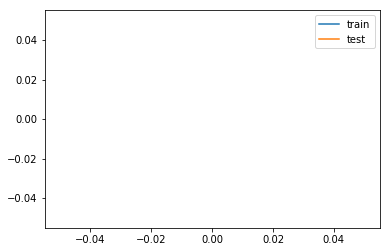

In [157]:
plt.plot(train_metrics_df.groupby("alpha_log")["accuracy"].mean(), label="train")
plt.plot(test_metrics_df.groupby("alpha_log")["accuracy"].mean(), label="test")
plt.legend()

In [158]:
train_metrics_df.sort_values("c")

,alpha,beta,c,accuracy,alpha_log
0,0,100.0,0.012454,0.000755,-inf
1,0,200.0,0.017683,0.000762,-inf
2,0,300.0,0.021688,0.000764,-inf
3,0,400.0,0.025061,0.000766,-inf
4,0,500.0,0.028031,0.000766,-inf
5,0,600.0,0.030715,0.000767,-inf
6,0,700.0,0.033184,0.000767,-inf
7,0,800.0,0.035480,0.000767,-inf
8,0,900.0,0.037637,0.000767,-inf
9,0,1000.0,0.039677,0.000767,-inf


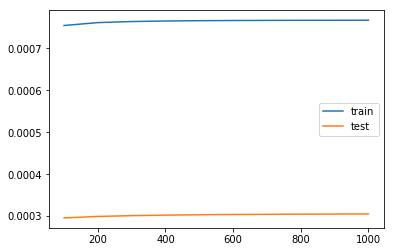

In [159]:
plt.plot(train_metrics_df.groupby("beta")["accuracy"].max(), label="train")
plt.plot(test_metrics_df.groupby("beta")["accuracy"].max(), label="test")
plt.legend()

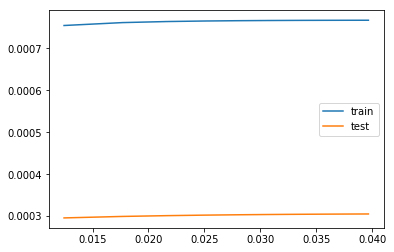

In [160]:
plt.plot(train_metrics_df.groupby("c")["accuracy"].max(), label="train")
plt.plot(test_metrics_df.groupby("c")["accuracy"].max(), label="test")
plt.legend()

# Airdrops search

- Считаем спрингранк для графа токенов